## Imports üì¶

In [1]:
import pandas as pd
import numpy as np
import emoji
import warnings
import nltk
from nltk.corpus import stopwords    
import string
import statistics

In [2]:
from matplotlib import pyplot as plt
import math
import seaborn as sns
import statistics

In [3]:
warnings.filterwarnings('ignore')

## Load Data üíø

In [4]:
df = pd.read_csv("Data/cleaned_by_language.csv")

In [5]:
en_df = df[df['language'] == 'en']
es_df = df[df['language'] == 'es']

In [6]:
en_comment = en_df['text only'].to_list()
es_comment = es_df['text only'].to_list()
en_comment_with_emoji = en_df['text'].to_list()
es_comment_with_emoji = es_df['text'].to_list()

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
en_stop_words = set(stopwords.words('english'))
es_stop_words = set(stopwords.words('spanish'))

def filter_comments(comment_list, stop_words):
    filtered_comments = []

    for comment in comment_list:
        # remove word starts with @
        comment = " ".join(filter(lambda x:x[0]!='@', comment.split()))
    
        # remove punctuations
        comment = comment.translate(str.maketrans('', '', string.punctuation))

        # remove stopwords
        words = nltk.word_tokenize(comment)
        filtered_comment = [word for word in words if word.lower() not in stop_words]
        filtered_comment = ' '.join(filtered_comment)
        filtered_comment = comment
        filtered_comments.append(filtered_comment)
    return filtered_comments

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aorawancraprayoon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aorawancraprayoon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
en_filtered_comments = filter_comments(en_comment, en_stop_words)
es_filtered_comments = filter_comments(es_comment, es_stop_words)
en_with_emoji_filtered_comments = filter_comments(en_comment_with_emoji, en_stop_words)
es_with_emoji_filtered_comments = filter_comments(es_comment_with_emoji, es_stop_words)

## Text Embeddings using LASER - this pretrained model supports cross-lingual tasks and embeds in setence-level

In [9]:
pip install laserembeddings

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
!/usr/bin/python3 -m laserembeddings download-models


‚úÖ   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
‚úÖ   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
‚úÖ   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

‚ú® You're all set!


In [11]:
# run this in terminal first: python -m laserembeddings download-models
from laserembeddings import Laser

laser = Laser()
en_text_array = laser.embed_sentences(en_filtered_comments, lang='en')
es_text_array = laser.embed_sentences(es_filtered_comments, lang='es')
en_array = laser.embed_sentences(en_with_emoji_filtered_comments, lang='en')
es_array = laser.embed_sentences(es_with_emoji_filtered_comments, lang='es')

In [12]:
en_text_array.shape

(280, 1024)

In [13]:
en_array.shape

(280, 1024)

## Emoji Embeddings using Emoji2Vec

In [14]:
from gensim.models import KeyedVectors

# Load pretrained emoji embeddings
emoji_model = KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)

def emoji_embedding(df):
    emoji_list_list = df['emoji list'].to_list()

    # Initialize a list to store emoji embeddings
    emoji_embedding = []

    for emoji_list in emoji_list_list:
        emoji_list_embedding = []  # Initialize a list for embeddings of each emoji list
        for emoji in emoji_list:
            try:
                emoji_list_embedding.append(emoji_model[emoji])
                
            except KeyError:
                pass

            # if len(emoji_list_embedding) != 0:
            # emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)
        emoji_embedding.append(emoji_list_embedding)
    
    # average
    res = []
    for embeddings in emoji_embedding:
        average_embedding = np.mean(embeddings, axis=0)
        # padded arrays with zero emojis with a length 300 array filled with zeros
        if average_embedding is None or np.isnan(average_embedding).all():
            res.append(np.zeros(300))
        else:
            res.append(average_embedding)
    
    return np.array(res)

# en_max_size = max(len(arr) for arr in en_emoji_embedding)
# en_padded_arrays = [np.pad(arr, (0, en_max_size - len(arr)), 'constant') for arr in en_emoji_embedding]
# en_emoji_array = np.vstack(en_padded_arrays)

In [15]:
en_emoji_array = emoji_embedding(en_df)
es_emoji_array = emoji_embedding(es_df)

In [16]:
es_emoji_array.shape

(280, 300)

##  Testing to see how many unique emojis in each comment (Don't run this part) üß™

In [17]:
# def emoji_embedding(df):
#     emoji_list_list = df['emoji list'].to_list()

#     # Initialize a list to store emoji embeddings
#     emoji_embedding = []
#     emoji_count = []
#     emoji_list_l = []

#     for emoji_list in emoji_list_list:
#         emoji_l = []
#         emoji_list_embedding = []  # Initialize a list for embeddings of each emoji list
#         count = 0
#         for emoji in emoji_list:
#             try:
#                 emoji_list_embedding.append(emoji_model[emoji])
#                 emoji_l.append(emoji)
#                 count+=1
                
#             except KeyError:
#                 pass
#         emoji_list_l.append(emoji_l)
#         emoji_count.append(count)

#         if len(emoji_list_embedding) != 0:
#             emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)
#         emoji_embedding.append(emoji_list_embedding)

#     return emoji_count, emoji_embedding, emoji_list_l

In [18]:
# en_emoji_count, en_emoji_embedding, es_emoji = emoji_embedding(en_df)
# es_emoji_count, es_emoji_embedding, en_emoji = emoji_embedding(es_df)

In [19]:
# list1 = []
# for i in es_emoji:
#     unique_set = set(i)
#     unique_list = list(unique_set)
#     list1.append(unique_list)
# list1 # a list of unique emojis in each comment (that can be handled by emoji2vec)
# counts = [len(inner_list) for inner_list in list1]

# zero_count = 0

# for item in counts:
#     if item == 0:
#         zero_count += 1
# zero_count

In [20]:
# list2 = []
# for i in en_emoji:
#     unique_set = set(i)
#     unique_list = list(unique_set)
#     list2.append(unique_list)
# list2 # a list of unique emojis in each comment (that can be handled by emoji2vec)
# counts2 = [len(inner_list) for inner_list in list2]

# zero_count2 = 0

# for item in counts2:
#     if item == 0:
#         zero_count2 += 1
# zero_count2

## Concatenate the text embeddings and emoji embeddings 

In [21]:
# Concatenate along columns (horizontally)
en_embeddings = np.concatenate((en_text_array, en_emoji_array), axis=1)
es_embeddings = np.concatenate((es_text_array, es_emoji_array), axis=1)

In [22]:
en_embeddings.shape

(280, 1324)

In [23]:
en_emoji_array.shape

(280, 300)

## Embedding Distributions üìä

In [24]:
def make_dist_df(arr):
    df = pd.DataFrame(arr)
    df['average'], df['min'], df['max']  = 0, 0, 0
    for idx, row in df.iterrows():
        df.at[idx, 'average'] = statistics.mean(row)
        df.at[idx, 'min'] = min(row)
        df.at[idx, 'max'] = max(row)
    return df

def df_embeddings(en_text_array, es_text_array, en_emoji_array, es_emoji_array):
    en_text_df = make_dist_df(en_text_array)
    en_text_df['type'] = 'en_text'
    es_text_df = make_dist_df(es_text_array)
    es_text_df['type'] = 'es_text'
    en_emoji_df = make_dist_df(en_emoji_array)
    en_emoji_df['type'] = 'en_emoji'
    es_emoji_df = make_dist_df(es_emoji_array)
    es_emoji_df['type'] = 'es_emoji'

    all_df = pd.concat([en_text_df[['min','max','average','type']],
                        es_text_df[['min','max','average','type']],
                        en_emoji_df[['min','max','average','type']],
                        es_emoji_df[['min','max','average','type']]])
    return all_df

(-0.15, 0.48)

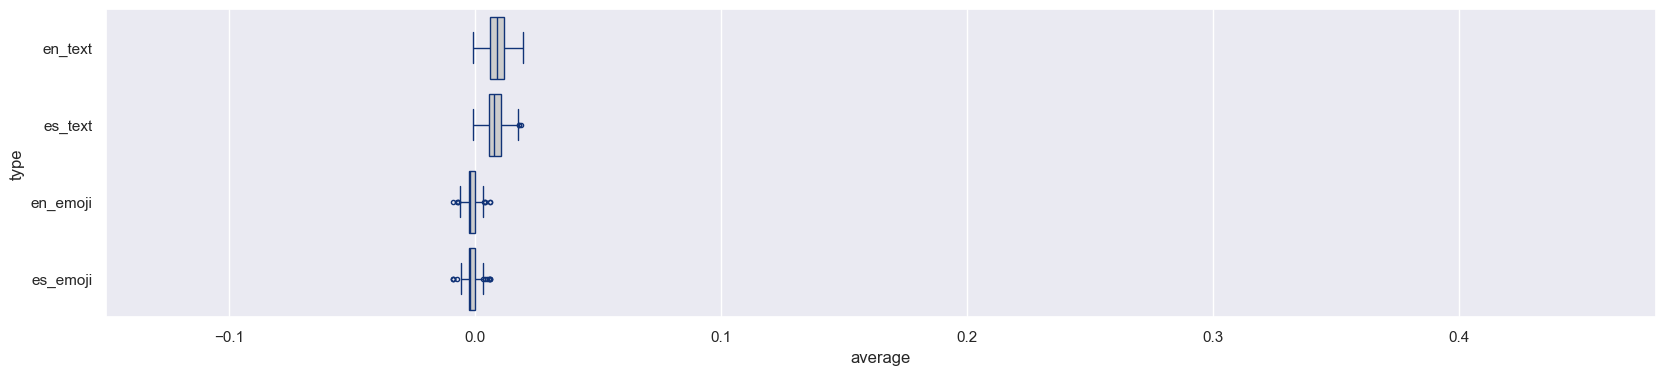

In [25]:
dist_df = df_embeddings(en_text_array, es_text_array, en_emoji_array, es_emoji_array)
sns.set(rc={'figure.figsize':(20,4)})

fig, ax = plt.subplots()
sns.boxplot(data=dist_df, x='average', y='type', color=".8", linecolor="#137", flierprops={"marker": "."})
ax.set_xlim(-0.15, 0.48)

(-0.15, 0.48)

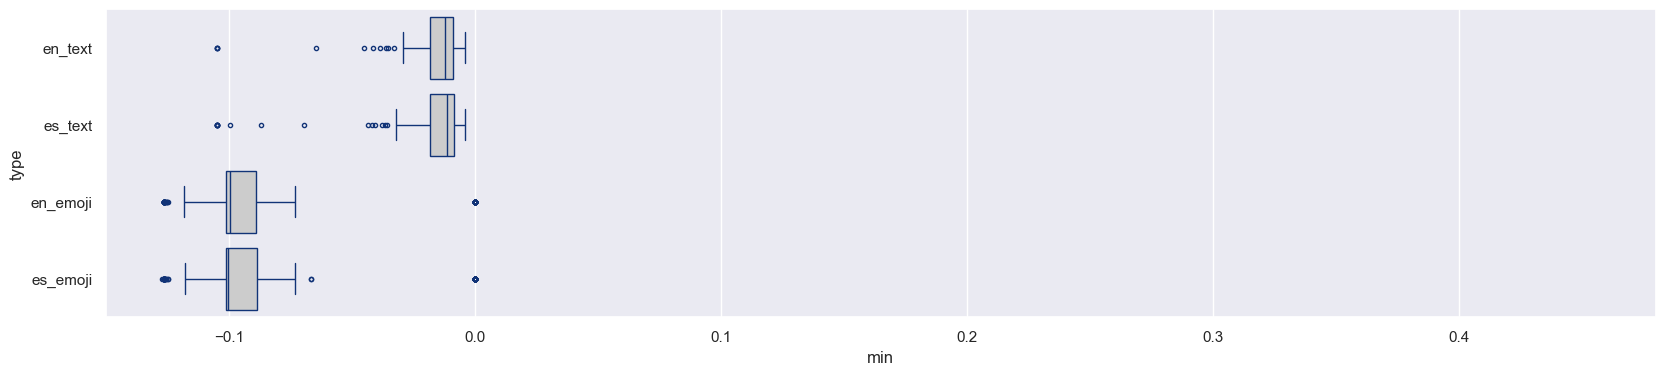

In [26]:
fig, ax = plt.subplots()
sns.boxplot(data=dist_df, x='min', y='type', color=".8", linecolor="#137", flierprops={"marker": "."})
ax.set_xlim(-0.15, 0.48)

(-0.15, 0.48)

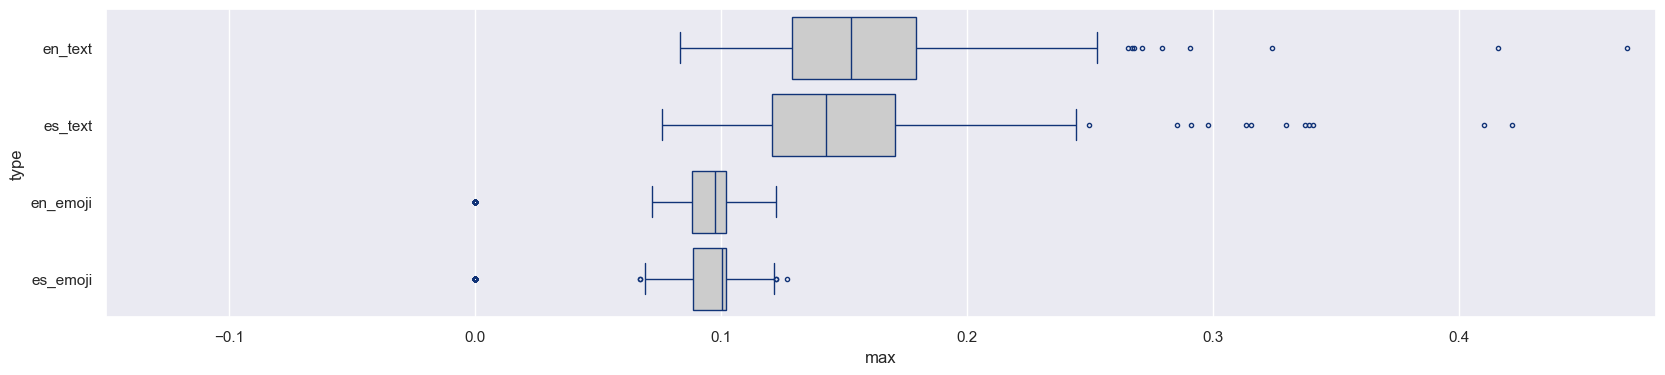

In [27]:
fig, ax = plt.subplots()
sns.boxplot(data=dist_df, x='max', y='type', color=".8", linecolor="#137", flierprops={"marker": "."})
ax.set_xlim(-0.15, 0.48)

## Variable names üìá
- en_text_array: LASER embeddings on text only (shape:280x1024)
- en_emoji_array: emoji2vec embeddings on emoji only (shape: 280x300)
- en_embeddings: concatenate en_text_array and en_emoji_array (shape: 280, 1324)
- en_array: LASER embeddings on text+emoji (shape: 280x1024)
- (replace en by es to get result from Spanish dataset)


## Try clustering using minibatch Kmeans -- concatenated word + emoji embeddings

In [28]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

### Determine optimal number of clusters

#### Distortion Score Elbow
- based on calculating the Within-Cluster-Sum of Squared Errors (WSS) for different number of clusters (k) and selecting the k for which change in WSS first starts to diminish.

In [29]:
pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


English

In [30]:
# referenced https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
# Elbow Method for K means
# Import ElbowVisualizer
# from yellowbrick.cluster import KElbowVisualizer
# model = KMeans()
# # k is range of number of clusters.
# visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
# visualizer.fit(en_embeddings)        # Fit data to visualizer
# visualizer.show()        # Finalize and render figure

Spanish

In [31]:
# referenced https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
# Elbow Method for K means
# Import ElbowVisualizer
# from yellowbrick.cluster import KElbowVisualizer
# model = KMeans()
# # k is range of number of clusters.
# visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
# visualizer.fit(es_embeddings)        # Fit data to visualizer
# visualizer.show()        # Finalize and render figure

#### Silhouette Coefficient Method

English

In [32]:
# Silhouette Score for K means
# Import ElbowVisualizer
# from yellowbrick.cluster import KElbowVisualizer
# model = KMeans()
# # k is range of number of clusters.
# visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
# visualizer.fit(en_embeddings)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

Spanish

In [33]:
# Silhouette Score for K means
# Import ElbowVisualizer
# from yellowbrick.cluster import KElbowVisualizer
# model = KMeans()
# # k is range of number of clusters.
# visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
# visualizer.fit(es_embeddings)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

#### Calinski-Harabasz Index

English

In [34]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
# from yellowbrick.cluster import KElbowVisualizer
# model = KMeans()
# # k is range of number of clusters.
# visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
# visualizer.fit(en_embeddings)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

Spanish

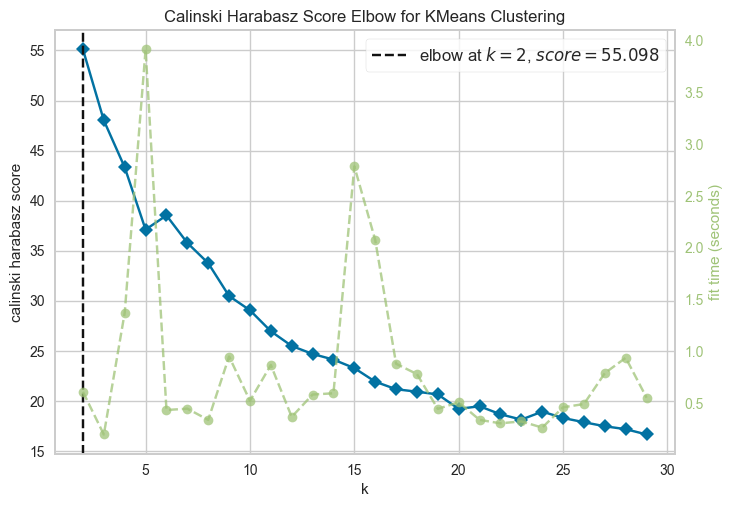

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [35]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(es_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Clustering Functions

In [36]:
# code from https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [37]:
def apply_cluster(lang_embeddings, lang_df, lang_filtered_comments, k):
    clustering, cluster_labels = mbkmeans_clusters(
        X=lang_embeddings,
        k=k,
        mb=500,
        print_silhouette_values=True,
    )
    df_clusters = pd.DataFrame({
        "text": lang_df['text'],
        "tokens": [" ".join(text) for text in lang_filtered_comments],
        "cluster": cluster_labels
    })
    return df_clusters

### English Results

In [38]:
en_df_clusters = apply_cluster(en_embeddings, en_df, en_filtered_comments, 11)

For n_clusters = 11
Silhouette coefficient: 0.14
Inertia:109.97831318985935
Silhouette values:
    Cluster 3: Size:15 | Avg:0.46 | Min:0.33 | Max: 0.52
    Cluster 4: Size:21 | Avg:0.44 | Min:0.27 | Max: 0.49
    Cluster 2: Size:15 | Avg:0.43 | Min:0.14 | Max: 0.49
    Cluster 10: Size:5 | Avg:0.42 | Min:0.40 | Max: 0.43
    Cluster 5: Size:13 | Avg:0.34 | Min:0.17 | Max: 0.40
    Cluster 6: Size:9 | Avg:0.29 | Min:-0.01 | Max: 0.43
    Cluster 9: Size:27 | Avg:0.17 | Min:0.03 | Max: 0.30
    Cluster 0: Size:66 | Avg:0.07 | Min:-0.06 | Max: 0.18
    Cluster 1: Size:45 | Avg:0.04 | Min:-0.09 | Max: 0.16
    Cluster 7: Size:26 | Avg:-0.04 | Min:-0.19 | Max: 0.07
    Cluster 8: Size:38 | Avg:-0.07 | Min:-0.19 | Max: -0.01


Top 3 English clusters

In [39]:
en_df_clusters[en_df_clusters['cluster']==4]['text'].tolist()

['We love you hazardsüî•üî•üî•',
 'The France üá´üá∑ is on Fire üî•',
 'dats literally my dad üî•',
 'Best player üî•üî•',
 '@pure_sh1thousery we are winer‚ù§Ô∏è‚ù§Ô∏èüî•üáÆüá∑üáÆüá∑üáÆüá∑üáÆüá∑',
 'My Favorite team üî•üî•',
 '@nadoosh_ku I agreed with you from Saudi Arabiaüî•üî•üî•',
 'Korea Vs Ghana was far better game üî•üî•',
 'Musiala all the wayüî•',
 'Rushford üî•',
 'Nice game üî•',
 '@beatbox_musicality For real broüî•üî•üî•',
 'Coolüî•',
 'Mbappe on another level in this world cupüî•üî•üî•‚ù§Ô∏è',
 'The big and champions France in Qatar2022üî•',
 '@farzad_1818 I like both team but wowwww Maroccco üî•',
 '@m.a.l.e.k.a.n.o_jr Just waitüî•',
 'Th rise of asian football ‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏èproudly all Asian can say japan is a Asian football country...,üî•üî•üî•',
 'So much ‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è for CR7üî•üî•',
 'Go Croatia!!üî•üî•',
 'Uff he was the best üî•üî•üòç']

In [40]:
en_df_clusters[en_df_clusters['cluster']==5]['text'].tolist()

['Best World Cup ever üòç',
 'Wow nice moves roboüòçüòçüòçüòçüòçüòçüòçüòç challenge accepted üî•üî•üî•üî•',
 "Congrates Ghana!! Great job u guys did.üòç But I still don't understand why did the referee decided that way. ü•≤",
 'Missing Italy in the world cupüòçüòçüòçüáÆüáπüáÆüáπüáÆüáπ',
 'Argentina 3.points win yees‚ù§Ô∏èüòò',
 'oooh jungkook and his song üòçAnd congratulations on the victory of the French',
 'Congratulations to Japan, Morocco, Brazil, South Korea and Qatar üòç',
 'HE SO FINE OMLL üòç',
 'Follow @__footycontent_ üòç',
 'France ‚ù§Ô∏èüòçand Argentina üòç‚ù§Ô∏è‚ù§Ô∏è',
 "Looking forward to Hakimi vs MBappe'üòç‚ù§Ô∏è May the best win!",
 "@el_dado1004 ya ya ya, croatia lost to spain 6-0 in 2018. You are the kid who couldn't handle the facts and couldnt help yourself but to run your fingers through my comment. Stay mad bestie üòç",
 '@hassan.ahmed.07 6 Games 5 goals 3 assist nowüòç']

In [41]:
en_df_clusters[en_df_clusters['cluster']==3]['text'].tolist()

['Netherlandsüëèüëèüëè and also cricket',
 'Definitely!!! üëèüëèüëèüëèüëè',
 '@pr1ncesa_mar1 never! Korea is much better team! üëè',
 'He is completely right! üëè',
 'hand ball üëè',
 'The Bluetooth goal üëè',
 '@itsabdelfatah you were right üëè',
 'respect üëè',
 'The Best goal of the world cupüëèüëèüëè‚öΩÔ∏è',
 'Just an amazing team great job üëèüèªüëèüèªüëèüèªüëèüèªüëèüèªüëèüèªüëèüèªüëèüèª‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è',
 '@reemasul_r3 there u go I told u guys yall can win too, good job üëèüèªüëèüèª u guys won fair and square, dont feel low for ur team. They are good enough alrdy üëèüèª',
 '@porti_elias Its True buddyüëèüëè',
 'Best of luck upcoming final game @afaseleccion üëèüëèüëèüèÜ',
 '@fabreezy_ üëèüëèüëè this is yours???',
 '@k.mbappe proud of youüëè']

### Spanish Results

Top 3 Spanish clusters

In [42]:
es_df_clusters = apply_cluster(es_embeddings, es_df, es_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.25
Inertia:105.64491628529683
Silhouette values:
    Cluster 3: Size:11 | Avg:0.41 | Min:0.17 | Max: 0.47
    Cluster 6: Size:35 | Avg:0.39 | Min:0.06 | Max: 0.54
    Cluster 4: Size:21 | Avg:0.38 | Min:0.03 | Max: 0.50
    Cluster 1: Size:68 | Avg:0.38 | Min:0.02 | Max: 0.45
    Cluster 7: Size:13 | Avg:0.37 | Min:0.02 | Max: 0.46
    Cluster 5: Size:14 | Avg:0.26 | Min:-0.02 | Max: 0.43
    Cluster 0: Size:10 | Avg:0.10 | Min:-0.07 | Max: 0.20
    Cluster 2: Size:108 | Avg:0.07 | Min:-0.12 | Max: 0.21


In [43]:
pip install translate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [44]:
from translate import Translator

In [45]:
translator = Translator(from_lang="es", to_lang='en')
es_df_clusters['translation'] = es_df_clusters['text'].apply(lambda x: translator.translate(x))

In [46]:
es_df_clusters[es_df_clusters['cluster']==7]['translation'].tolist()
es_df_clusters[es_df_clusters['cluster']==7]['text'].tolist()

['Nuestro √∫ltimo partido en un mundial üá®üá¥üò¢',
 'Como molan mis negritos üò¢',
 '@fifaworldcup Ecuador se merec√≠a el pase üò¢',
 'Que bueno que sos üò≠üò≠üò≠',
 'A√∫n dueleüò¢',
 'y mechico?üò¢',
 '@guiguelpaulo üò¢',
 'Merecias ganar japon üò¢',
 'Neymar Da Silva Santos Junior üò¢',
 '@mdsojid364 llora brasile√±o üò¢',
 'Casillas lloronüò¢',
 'Jam√°s pens√© que un mundial del cu√°l tantas personas esperaban ver calidad est√© siendo tan manipulado y arreglado c√≥mo est√©, quer√≠amos ver transparencia con buenos jugadores dej√°ndolo todo en la cancha pero al final solo hemos visto fraude,mentiras y enga√±√≥ con la mayor√≠a de equipos que han salido, hasta los √°rbitros parecen comprados porque han pitado penaltis inexistente para favorecer a los equipos que deseaban ver en la final, QUE TRISTEZA EST√â MUNDIAL DE QATAR 2022 üò¢üò¢üò¢.',
 'La final la juegan 2 equipos......que gran decepci√≥n este mundial üò¢']

In [47]:
t7 = ['With everything maes üî•üá®üá∑','The master magicianüî•üî•  üëèüèª‚ö°',
 'We love you @yosoy8a üá≤üáΩüî•',
 'Let\'s go Spain üî•',
 'Life changes when it starts to focus on youüé∂üî•',
 '@sandra_cariel cameeron 100% √©liminer üî•üî•',
 '@hoonjy you guys, if those shots didn\'t hit the stick uffffüî•',
 'It will be that they break the curseüî•üî•üî•',
 'Valenciaüî•üî•üî•',
 'All my faith for Argentina üî•',
 '@pablogavi good lucküî•',
 '@deyaneira_ae what a qualification Valencia gave in Senegal\'s 2nd goalüôåüî•üî•',
 'The MESSIAS is back üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑ Let\'s go Selection üî•üî•üî•',
 'Ronaldoüî•üî•üî•üî•',
 'Aidouniüî•‚ù§Ô∏è',
 '@hilla_loaiza what level üî•üî•üî•',
 'What a great game from this manüî•',
 'Argentina üî•üíö',
 'Trioos are always good bro üî•üòâ',
 'The best in the world! ‚ù§Ô∏è\u200düî•‚ù§Ô∏è\u200düî•',
 'üòç√±üî•üî•üî•',
 'ComOn Argentina..you can do it üî•‚ù§Ô∏èüî•',
 'Let\'s go Argentina üî•üî•',
 'It was an exquisite match üî•',
 'Argentina wins üî•üî•üî•‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è',
 'üî•üî•üî•üëèüôå mexico üá≤üáΩ',
 'Argentina, Alvaresüî•',
 'üî•Argentina. 3 üî• France 1üî•',
 'Argentina üòç‚ù§Ô∏èüî•üî•',
 'Roberto üî•üî•']
t7

['With everything maes üî•üá®üá∑',
 'The master magicianüî•üî•  üëèüèª‚ö°',
 'We love you @yosoy8a üá≤üáΩüî•',
 "Let's go Spain üî•",
 'Life changes when it starts to focus on youüé∂üî•',
 '@sandra_cariel cameeron 100% √©liminer üî•üî•',
 "@hoonjy you guys, if those shots didn't hit the stick uffffüî•",
 'It will be that they break the curseüî•üî•üî•',
 'Valenciaüî•üî•üî•',
 'All my faith for Argentina üî•',
 '@pablogavi good lucküî•',
 "@deyaneira_ae what a qualification Valencia gave in Senegal's 2nd goalüôåüî•üî•",
 "The MESSIAS is back üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑ Let's go Selection üî•üî•üî•",
 'Ronaldoüî•üî•üî•üî•',
 'Aidouniüî•‚ù§Ô∏è',
 '@hilla_loaiza what level üî•üî•üî•',
 'What a great game from this manüî•',
 'Argentina üî•üíö',
 'Trioos are always good bro üî•üòâ',
 'The best in the world! ‚ù§Ô∏è\u200düî•‚ù§Ô∏è\u200düî•',
 'üòç√±üî•üî•üî•',
 'ComOn Argentina..you can do it üî•‚ù§Ô∏èüî•',
 "Let's go Argen

In [48]:
# es_df_clusters[es_df_clusters['cluster']==1]['translation'].tolist()
es_df_clusters[es_df_clusters['cluster']==4]['text'].tolist()

['üëèüëèvamos con todo, strong',
 'Felicidades a Ecuador por ganarle a los esclavistas üëèüèºüëèüèº',
 '15 mundiales üëèüëèüëè',
 'El mejor de todos ‚ù§Ô∏èüëè',
 'üëèüëèVamos ticos que si se puede , recurren cuando salieron del grupo de la muerte en el 2014  cuando todos los daban por muertos y los muertos resultaron ser otros . Vamos ticos que a√∫n que mi equipo es USA pero mi coraz√≥n se lo ganaron en aquel mundial 2014 . Sino es mi USA son ustedes para mi . ‚ù§Ô∏è',
 'Ecuador presente üá™üá®üëèüëè',
 'Maradona lo ayudar a Messi para lograr el triunfo ‚ù§Ô∏èüëèüëèüëè',
 'El mejor del mundo üëèüèª üòç',
 'El mejor de Portugal üëèüëè',
 'Orgullo mexicano ‚ù§Ô∏èüëèüèªüá≤üáΩ',
 'Mejor que publiquen los momentos de goles anulados üëèüëè',
 '@caro2653 üëèüëèüëè',
 'Un grande mi t√≠o RIL O üëèüëèüëè @dorian_ybaceta @lopezillo.public @hugo_charcape03 @henrykux03',
 'Gracias por todo Cristiano Ronaldo! El mejor jugador y atleta de la Historia de la Humanida

In [49]:
t4 = ['Proudly Ecuadorians üòç',
 '‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è Ecuadorians üòçüòçüòçüòçüòç',
 '@btito_.avak best goalkeeper in the world, proceeds to lose 7 to 0üòçüòçüòç',
 'Eden hazard comes backüòçüòçüòç',
 'love banget idola saya portugal - Cristiano Ronaldo.üòç',
 'I have always liked Ghanaian uniformsüòç',
 'Love the France shirt üòçüòçüòç üá∫üáæüá®üáµ',
 'Lol Casillas!!! üòçüòç',
 'thank you üòç',
 '@sebassss_07 our goal is to win the world championships, not to participate üòò',
 'üòçronaldo']
t4

['Proudly Ecuadorians üòç',
 '‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è Ecuadorians üòçüòçüòçüòçüòç',
 '@btito_.avak best goalkeeper in the world, proceeds to lose 7 to 0üòçüòçüòç',
 'Eden hazard comes backüòçüòçüòç',
 'love banget idola saya portugal - Cristiano Ronaldo.üòç',
 'I have always liked Ghanaian uniformsüòç',
 'Love the France shirt üòçüòçüòç üá∫üáæüá®üáµ',
 'Lol Casillas!!! üòçüòç',
 'thank you üòç',
 '@sebassss_07 our goal is to win the world championships, not to participate üòò',
 'üòçronaldo']

In [50]:
# es_df_clusters[es_df_clusters['cluster']==8]['translation'].tolist()
es_df_clusters[es_df_clusters['cluster']==1]['text'].tolist()

['Que seductor el de la segunda foto üòÇüòÇ',
 '@magggitomcruz ya estamos en la copa, se llama USA üá∫üá∏ lmao p3nd3j0 üòÇüòÇ',
 'Osea el uno tapa penal el otro hace gol y este es el mejor del partido es lo de ayer Ferr√°n hizo los 2 goles y grande jugadas y el mejor fue Gavi üòÇüòÇ',
 '@daje_mitico üòÇüòÇ',
 '@lauhernandezchavez La Payasada Les sali√≥ caro üòÇ',
 'Poor guy üòÇ',
 'Ecuador los hizo bailar los humill√≥ y supuestamente este qued√© como mejor jugador üòÇ tras que anulan  un gol leg√≠timo, tambi√©n meten mano en el mejor jugador cuando todo el mundo se di√≥ cuenta perfectamente que Ecuador los super√≥, que descarados que son',
 'üòÇ Ronaldo',
 'Se mueve m√°s una cucaracha con baygonüòÇ',
 '@jomiguelrivera el gol del siglo se lo hicimos a italiaüòÇ',
 'Que buen negocio el de nuestra selecci√≥n üòÇ',
 'Mierda üòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇ',
 '@bertonrayhs_ üòÇüòÇüòÇla tenes adentroüá¶üá∑üá¶üá∑',
 'Los de Arabia Saud√≠ se quieren morir estaban conte

In [51]:
t1 = ['How seductive the one in the second photo üòÇüòÇ',
 '@magggitomcruz we are already in the cup, it\'s called USA üá∫üá∏ lmao p3nd3j0 üòÇüòÇ',
 'I mean, one blocks a penalty, the other scores a goal and this is the best of the game, it\'s what happened yesterday, Ferr√°n scored the 2 goals and great plays and the best was Gavi üòÇüòÇ',
 '@daje_mitico üòÇüòÇ',
 '@lauhernandezchavez La Payasada was expensive for them üòÇ',
 'Poor guy üòÇ',
 'Ecuador made them dance, humiliated them and supposedly this was the best player üòÇ after they annulled a legitimate goal, they also put their hands on the best player when everyone realized perfectly well that Ecuador surpassed them, how shameless they are',
 'üòÇRonaldo',
 'A cockroach moves more with baygonüòÇ',
 '@jomiguelrivera we scored the goal of the century against ItalyüòÇ',
 'What a good deal for our team üòÇ',
 'Shit üòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇ',
 '@bertonrayhs_ üòÇüòÇüòÇyou have it insideüá¶üá∑üá¶üá∑',]
t1

['How seductive the one in the second photo üòÇüòÇ',
 "@magggitomcruz we are already in the cup, it's called USA üá∫üá∏ lmao p3nd3j0 üòÇüòÇ",
 "I mean, one blocks a penalty, the other scores a goal and this is the best of the game, it's what happened yesterday, Ferr√°n scored the 2 goals and great plays and the best was Gavi üòÇüòÇ",
 '@daje_mitico üòÇüòÇ',
 '@lauhernandezchavez La Payasada was expensive for them üòÇ',
 'Poor guy üòÇ',
 'Ecuador made them dance, humiliated them and supposedly this was the best player üòÇ after they annulled a legitimate goal, they also put their hands on the best player when everyone realized perfectly well that Ecuador surpassed them, how shameless they are',
 'üòÇRonaldo',
 'A cockroach moves more with baygonüòÇ',
 '@jomiguelrivera we scored the goal of the century against ItalyüòÇ',
 'What a good deal for our team üòÇ',
 'Shit üòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇ',
 '@bertonrayhs_ üòÇüòÇüòÇyou have it insideüá¶üá∑üá¶üá∑']

## Clustering with LASER Embeddings on text only

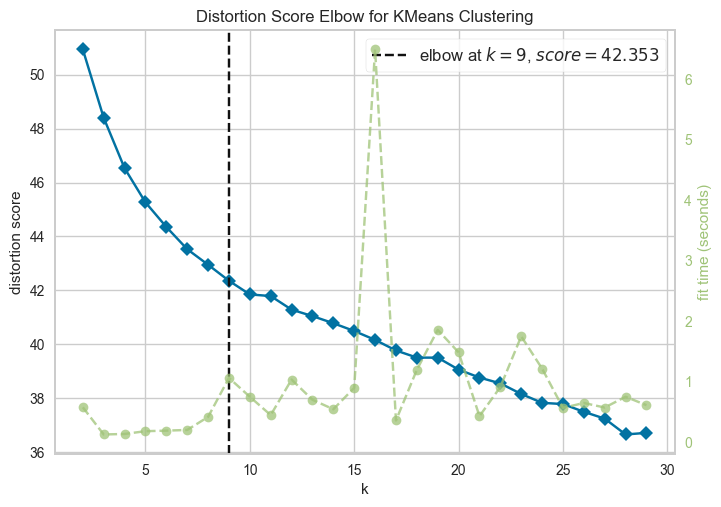

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
# referenced https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(en_text_array)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [53]:
en_df_clusters_laser = apply_cluster(en_text_array, en_df, en_filtered_comments, 10)

For n_clusters = 10
Silhouette coefficient: 0.04
Inertia:43.13398742675781
Silhouette values:
    Cluster 3: Size:16 | Avg:0.27 | Min:0.10 | Max: 0.39
    Cluster 7: Size:16 | Avg:0.11 | Min:-0.04 | Max: 0.24
    Cluster 4: Size:2 | Avg:0.07 | Min:0.07 | Max: 0.08
    Cluster 5: Size:90 | Avg:0.05 | Min:-0.06 | Max: 0.11
    Cluster 0: Size:42 | Avg:0.03 | Min:-0.03 | Max: 0.11
    Cluster 8: Size:10 | Avg:0.02 | Min:-0.01 | Max: 0.06
    Cluster 2: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 9: Size:23 | Avg:-0.01 | Min:-0.07 | Max: 0.04
    Cluster 6: Size:54 | Avg:-0.02 | Min:-0.06 | Max: 0.04
    Cluster 1: Size:26 | Avg:-0.02 | Min:-0.08 | Max: 0.02


In [54]:
en_df_clusters_laser[en_df_clusters_laser['cluster']==3]['text'].tolist()

['Sonü•∫',
 '@_francechy_ ü§£ü§£ü§£',
 '@the_real_thorstinho #onetwo ü§≠ü§≠ü§≠ü§≠ü§≠',
 'Definitely!!! üëèüëèüëèüëèüëè',
 'Rushford üî•',
 '@anchan_0722_ üòÇüòÇüòÇ',
 '@88godiswithme üòÇüòÇüòÇüòÇüòÇüòÇüòÇ congratulations!!',
 'Congratulations üî•üëè',
 'respect üëè',
 'Coolüî•',
 '@spasho05 üòÇüòÇüòÇüòÇ',
 'Richarlison üóøüç∑',
 'Caption üíØ',
 '@robertmikocevic yes üòâüòâüî•',
 'Follow @__footycontent_ üòç',
 '@shreyanshpathak8717 üòÇ']

In [55]:
en_df_clusters_laser[en_df_clusters_laser['cluster']==4]['text'].tolist()

['Congrats and well done toüáßüá™@belgianreddevils who wins and wish the best and good luck too in the next match againstüá≤üá¶@equipedumaroc and forüá®üá¶@canadasoccer ,well done for fights until the end despite lost and wish the best and good luck too in the next match againstüá≠üá∑@hns_cff !üëèüôÇüòÄüòÑüòéüëç‚öΩÔ∏è',
 "I'm heartbroken that we didn't do enough to go the next round, but in the end, we fought hard. üíî And we're gonna continue fighting! They haven't seen the last of Mexico, at all! üî• See you all in 2026!! üá≤üáΩüá≤üáΩüíØüíØ"]

In [56]:
en_df_clusters_laser[en_df_clusters_laser['cluster']==6]['text'].tolist()

["@ryjpopp yeah says the people who can't Offord a stay in Qatar üòÇ",
 '@glg_sky yeah I‚Äôm sure Qatar being ranked financially behind Greece means they‚Äôre thriving üôÑ',
 'Netherlandsüëèüëèüëè and also cricket',
 'Nice trophy..smile it..get it..your trophy..üèÜ‚úåüòÑ',
 'This nikka sick wit itüî•üòÇ',
 'Rainbow üåàüåàüåà shame on fifa',
 '@matheusgmezz u are goofy as hecküòÇ',
 'Why they burn Eden with the food question? üòÇ @albert810 @chelo23',
 'But you start to tremble knowing you face Saudi Arabia üá∏üá¶ üòÜ',
 '@exclusivelysania you are complaining in every post get a life üòÇ',
 "Hazard's the only reason im a chelsea fan üêêüíô",
 '@audrey_loves_nature_art this is word cup no campaign you regionüôè',
 '@gokselinia they all good, u are the one being racist u woman with cartoon tshirt or I say Karenüë©üèª\u200dü¶∞',
 'Wow nice moves roboüòçüòçüòçüòçüòçüòçüòçüòç challenge accepted üî•üî•üî•üî•',
 'Howtf is he the man of the match? üòÇ',
 'Af

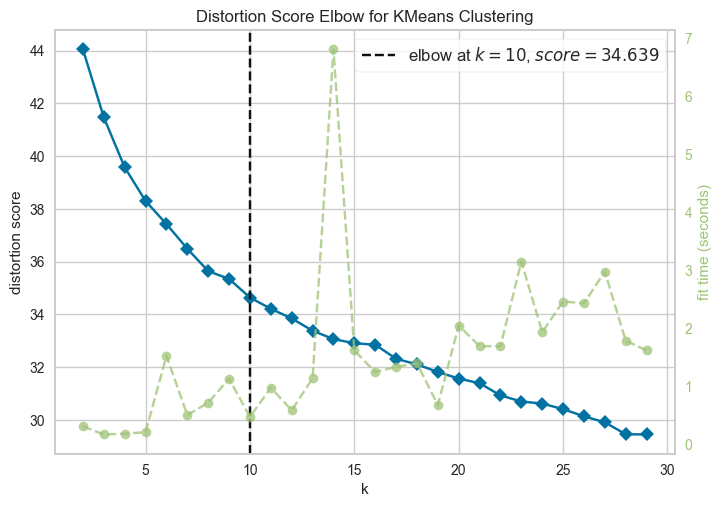

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [57]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(es_text_array)        # Fit data to visualizer
visualizer.show()     

In [58]:
es_df_clusters_laser = apply_cluster(es_text_array, es_df, es_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.04
Inertia:36.71879196166992
Silhouette values:
    Cluster 0: Size:31 | Avg:0.19 | Min:0.04 | Max: 0.32
    Cluster 3: Size:15 | Avg:0.14 | Min:-0.04 | Max: 0.32
    Cluster 1: Size:39 | Avg:0.08 | Min:0.01 | Max: 0.14
    Cluster 6: Size:27 | Avg:0.02 | Min:-0.05 | Max: 0.12
    Cluster 2: Size:30 | Avg:0.01 | Min:-0.09 | Max: 0.12
    Cluster 5: Size:61 | Avg:0.00 | Min:-0.07 | Max: 0.07
    Cluster 4: Size:28 | Avg:-0.00 | Min:-0.10 | Max: 0.05
    Cluster 7: Size:49 | Avg:-0.02 | Min:-0.09 | Max: 0.05


In [ ]:
# es_df_clusters_laser['translation'] = es_df_clusters_laser['text'].apply(lambda x: translator.translate(x))

In [59]:
es_df_clusters_laser[es_df_clusters_laser['cluster']==3]['text'].tolist()

['Ecuador! üá™üá®üá™üá®üá™üá®üá™üá®‚ù§‚ù§',
 'Ame la camiseta de Francia üòçüòçüòç üá∫üáæüá®üáµ',
 'ECUADOR IN DA HOUSE üî•üî•üî•üî•üî•üî•üá™üá®üá™üá®üá™üá®üá™üá®üá™üá®üá™üá®üá™üá®üôåüôåüôåüôåüôåüôåüôåüôå #ecuadorarrechohp',
 '@bertonrayhs_ üòÇüòÇüòÇla tenes adentroüá¶üá∑üá¶üá∑',
 'Argentina üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üôå',
 'Volvi√≥ el MESSIAS üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑ Vamos Selecci√≥n üî•üî•üî•',
 '@tacianebarros_ vamos argentina viva diego üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üíôüíôüèÜ',
 'Argentina üá¶üá∑üá¶üá∑üí•üí•üíô',
 '@memphisdepay argentina 5 Holanda 1 üòé',
 'El postre preferido de MESSI üîüüá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑',
 'Argentina üá¶üá∑üèÜüá¶üá∑‚ù§Ô∏è',
 'üî•üî•üî•üëèüôå mexico üá≤üáΩ',
 'üî•Argentina.  3 üî•  Francia  1üî•',
 'Primero...no lo hace tan bien, segundo...BrasiiiiiilllllüòÇüòÇüòÇüá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑',
 'Ar

In [60]:
es_df_clusters_laser[es_df_clusters_laser['cluster']==1]['text'].tolist()

['Felicidades Ecuador! üôå',
 'üëèüëèvamos con todo, strong',
 'Con todo maes üî•üá®üá∑',
 'Vamos Per√∫ ‚ù§Ô∏è',
 'Vamos Espana üôå',
 'Vamos Marruecos ‚ù§Ô∏è',
 '@bbsitaj ya vamos a ver el 18 de diciembre üòâ',
 'Te amamos @yosoy8a üá≤üáΩüî•',
 'Eden ‚ù§Ô∏è',
 'Vamos Espa√±a üî•',
 '@queenfir_ marocco ‚ù§Ô∏è‚ù§Ô∏è',
 '15 mundiales üëèüëèüëè',
 'El mejor de todos ‚ù§Ô∏èüëè',
 'Lamentablemente lo vi üòî',
 '@pablogavi buena suerteüî•',
 'El mejor del mundo üëèüèª üòç',
 'El mejor de Portugal üëèüëè',
 'Aidouniüî•‚ù§Ô∏è',
 '@fabilleao c√°llate la boca andaü§´ü§´',
 'Que bueno que sos üò≠üò≠üò≠',
 'A√∫n dueleüò¢',
 '@hilla_loaiza que nivel üî•üî•üî•',
 'Pride? üè≥Ô∏è\u200düåà?',
 '@qp11_00 Incredible videoüëç',
 '@j_fonse10 üòÇüòÇüòÇyo tambien ati',
 'Maroc‚ù§Ô∏è',
 '@carolinacbarbos Bonoüá≤üá¶üëä',
 '@vinicius_conrado12 bye bye brazilüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÖ',
 'Ronaldo‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è',
 'Vamos Argentina üî•üî•',
 'Fue un par

## Clustering with LASER Embeddings on text + emoji

In [61]:
model = KMeans()
# # k is range of number of clusters.
# visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
# visualizer.fit(en_array)        # Fit data to visualizer
# visualizer.show()        # Finalize and render figure

In [62]:
en_df_clusters_laser_with_emoji = apply_cluster(en_array, en_df, en_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.03
Inertia:42.29527282714844
Silhouette values:
    Cluster 5: Size:35 | Avg:0.19 | Min:0.09 | Max: 0.30
    Cluster 3: Size:49 | Avg:0.07 | Min:-0.02 | Max: 0.14
    Cluster 1: Size:15 | Avg:0.01 | Min:-0.01 | Max: 0.05
    Cluster 7: Size:12 | Avg:0.01 | Min:-0.03 | Max: 0.04
    Cluster 2: Size:30 | Avg:-0.00 | Min:-0.06 | Max: 0.09
    Cluster 4: Size:14 | Avg:-0.01 | Min:-0.04 | Max: 0.03
    Cluster 6: Size:68 | Avg:-0.02 | Min:-0.14 | Max: 0.06
    Cluster 0: Size:57 | Avg:-0.02 | Min:-0.11 | Max: 0.07


In [63]:
en_df_clusters_laser_with_emoji[en_df_clusters_laser_with_emoji['cluster']==1]['text'].tolist()

['no bro many moroccans respect Croatia team, was a game full of fair-play üëåüèΩ',
 '@iuchinouen what does that have to do with my overall intelligence ? I would say you are the dump one here for not answering in a full sentence and for minding to girls dating business. You poor thing musst have a boring and sad life üòÇ',
 '@aa.09_05 In 2010 Messi  just went to South Africa and let my guy Diego Maradona down, Maradona realised why Ronaldo is superior to Messi after that World Cup üòÇ',
 "Congrates Ghana!! Great job u guys did.üòç But I still don't understand why did the referee decided that way. ü•≤",
 'All I watch was pessi missing a pen a 3 big chances in front of the goal üòÇüòÇüòÇüòÇüëè small game player',
 "I will wait for the Portugal match, and we are very sorry for Portugal's victory for Cristiano Ronaldo, because he will not be able to participate again in the World Cup if he does not win the cup this time ü§çüáµüáπ",
 'Man i Park 300 bags of cement in an hour 

In [64]:
en_df_clusters_laser_with_emoji[en_df_clusters_laser_with_emoji['cluster']==5]['text'].tolist()

['Sonü•∫',
 '@_francechy_ ü§£ü§£ü§£',
 '@goodthanksyourself nice goal‚ù§Ô∏è',
 '@smithswith_ ‚ù§Ô∏èso good!!',
 '@jan_schawe to what üòÇüòÇüòÇüòÇüòÇ',
 '@5400.seconds are u there bro? ü§£',
 'Italy >>‚ù§Ô∏è',
 'Bro was forced to do itüòÇüòÇüòÇüòÇüòÇ',
 'Mount‚ù§Ô∏è',
 'He is completely right! üëè',
 '@hana_photographyc üòÇ Well done üëè',
 '@tina.f.aoun @gretta.khoury_ bs rebho aalaykunüòÇüòÇüòÇüòÇüòÇ',
 '@realestate_topg what happened ü§£ü§£',
 'Loveee this ‚ù§Ô∏è',
 '@itsabdelfatah you were right üëè',
 'Nice game üî•',
 '@kourosh_offiziell üáßüá∑üáßüá∑üèÜüèÜüèÜüèÜüèÜ ü§´',
 '@anchan_0722_ üòÇüòÇüòÇ',
 '@88godiswithme üòÇüòÇüòÇüòÇüòÇüòÇüòÇ congratulations!!',
 'the last one üíÄ',
 'Congratulations üî•üëè',
 'respect üëè',
 'Coolüî•',
 '@spasho05 üòÇüòÇüòÇüòÇ',
 '@m.a.l.e.k.a.n.o_jr Just waitüî•',
 '@ash.saalax üòÇ what about it now',
 'Caption üíØ',
 '@enkiduh how about now üòÇüòÇüòÇüòÇüòÇ ‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è'

In [ ]:
# model = KMeans()
# # k is range of number of clusters.
# visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
# visualizer.fit(es_array)        # Fit data to visualizer
# visualizer.show()        # Finalize and render figure

In [66]:
es_df_clusters_laser_with_emoji = apply_cluster(es_array, es_df, es_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.04
Inertia:35.43350601196289
Silhouette values:
    Cluster 4: Size:23 | Avg:0.16 | Min:0.04 | Max: 0.30
    Cluster 2: Size:51 | Avg:0.12 | Min:0.02 | Max: 0.22
    Cluster 6: Size:5 | Avg:0.06 | Min:0.03 | Max: 0.11
    Cluster 1: Size:22 | Avg:0.03 | Min:-0.13 | Max: 0.22
    Cluster 5: Size:42 | Avg:0.03 | Min:-0.04 | Max: 0.13
    Cluster 0: Size:47 | Avg:0.02 | Min:-0.06 | Max: 0.09
    Cluster 3: Size:50 | Avg:-0.02 | Min:-0.11 | Max: 0.07
    Cluster 7: Size:40 | Avg:-0.03 | Min:-0.09 | Max: 0.03


In [67]:
es_df_clusters_laser_with_emoji[es_df_clusters_laser_with_emoji['cluster']==3]['text'].tolist()

['@ikercasillasrules No veo donde sale neuer en el video üòÆ',
 'Cambien la bandera, somos Ecuador üá™üá®‚òùüèª',
 'Nuestro √∫ltimo partido en un mundial üá®üá¥üò¢',
 'I need an ice Pepsi Blue üòãüòãüòãüòãüòã joder, ser√° que este a√±o no la  lanzar√°n??? ü§îü§îü§î',
 'Felicidades a Ecuador por ganarle a los esclavistas üëèüèºüëèüèº',
 '@btito_.avak mejor portero del mundo, procede a perder 7 a 0üòçüòçüòç',
 'Nadie va a comentar la facha que destila el DT de la selecci√≥n? üåöüòà',
 'La vida cambia cuando empieza a enfocarse en tiüé∂üî•',
 'Hola Buena noche es Portugal ‚öΩÔ∏èüëçüáµüáπ',
 '@hichemourad13 ser√° que sigue pensado igual este individuo?  Ecuador es grande üá™üá®üòâüòâ',
 'Para mi tambi√©n ser√≠a como ver a Papa Noel! Te amamos Leo üá¶üá∑‚öΩÔ∏èüí™ü•∞',
 '@borenia grs!!! üî•üôå‚ù§Ô∏è futbol es f√∫tbol',
 'An√≥talo papi .....Vamos Ecuador üá™üá®ü•∞‚ù§Ô∏è‚ù§Ô∏è',
 '"Maurice ya no puedo moverlo mover moverlo" ‚ùåü¶µüò≠',
 '@zeferinooo.

In [68]:
es_df_clusters_laser_with_emoji[es_df_clusters_laser_with_emoji['cluster']==4]['text'].tolist()

['@daje_mitico üòÇüòÇ',
 'Eden ‚ù§Ô∏è',
 'Lamentablemente lo vi üòî',
 'gracias üòç',
 '@luisitorres_ s√≠ ü•µ',
 'Mierda üòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇ',
 '@pablogavi buena suerteüî•',
 '@fabilleao c√°llate la boca andaü§´ü§´',
 'A√∫n dueleüò¢',
 '@guiguelpaulo üò¢',
 '@caro2653 üëèüëèüëè',
 '@_arabicqueen_ dreamüòÇüòÇ',
 '@j_fonse10 üòÇüòÇüòÇyo tambien ati',
 'üòç√±üî•üî•üî•',
 '@vinicius_conrado12 bye bye brazilüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÖ',
 'Croacia üòÇüòÇüòÇüòÇüòÇ',
 'Paquet√° ü•µ',
 '@acdc.jpedro üòÇüòÇüòÇüòÇüòÇ',
 '@liga_profesional_de_truco üëçüèª',
 '@lovely_angel_kh no te entiendo pero, oküôå',
 '@b.local üòÇüòÇüòÇüëè',
 'Que dia horr√≠vel üòû',
 '@laparra_1 üëÄ']

# Visualize Clusters üé®

In [69]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### PCA -> TSNE

#### English

In [195]:
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(en_embeddings)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(principalComponents)

en_df_clusters = en_df_clusters.reset_index()
en_df_clusters = en_df_clusters.drop(['index'], axis=1)

tsne_df = en_df_clusters
tsne_df['PC1'] = tsne_pca_results[:,0]
tsne_df['PC2'] = tsne_pca_results[:,1]

tsne_df_en = tsne_df.copy()

<Axes: xlabel='PC1', ylabel='PC2'>

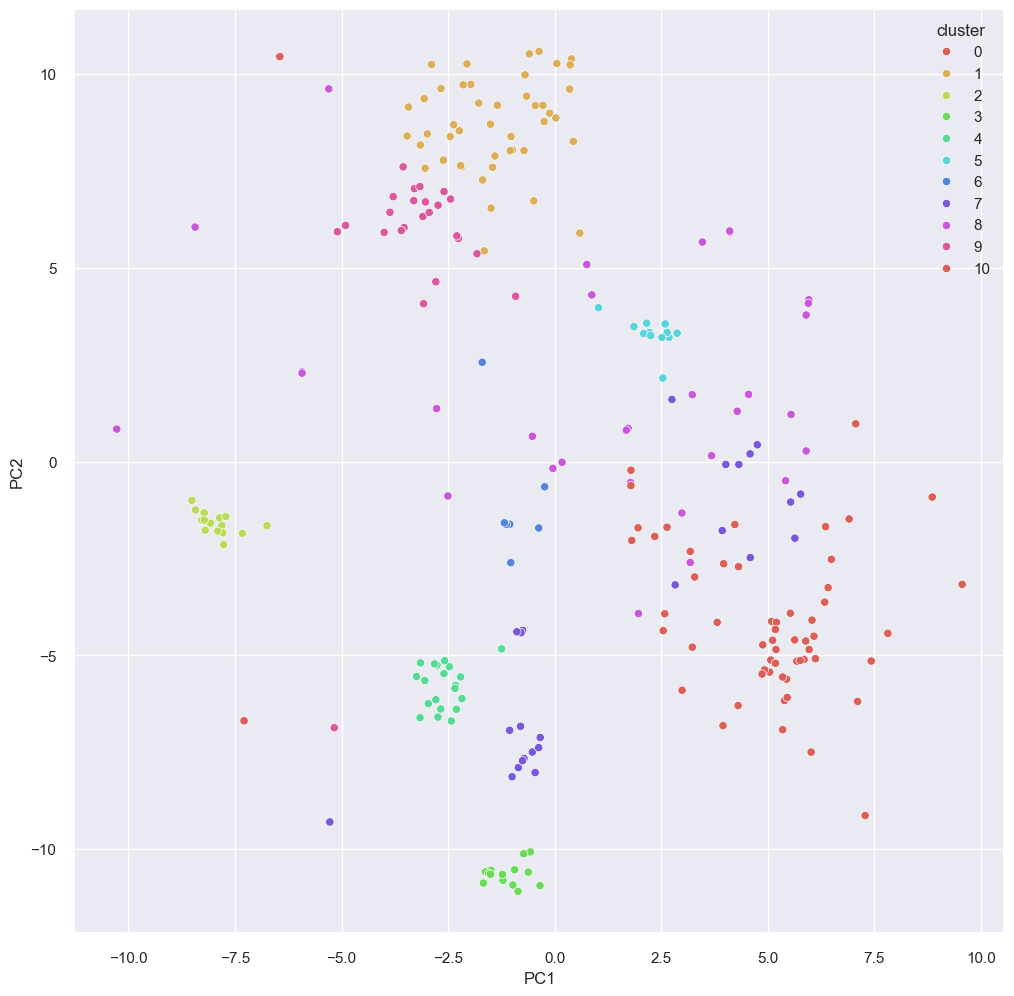

In [75]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(data=tsne_df_en, x='PC1', y='PC2', hue='cluster', palette=sns.color_palette("hls",10), legend="full")

#### Spanish

In [196]:
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(es_embeddings)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(principalComponents)

es_df_clusters = es_df_clusters.reset_index()
es_df_clusters = es_df_clusters.drop(['index'], axis=1)

tsne_df = es_df_clusters
tsne_df['PC1'] = tsne_pca_results[:,0]
tsne_df['PC2'] = tsne_pca_results[:,1]

tsne_df_es = tsne_df.copy()

<Axes: xlabel='PC1', ylabel='PC2'>

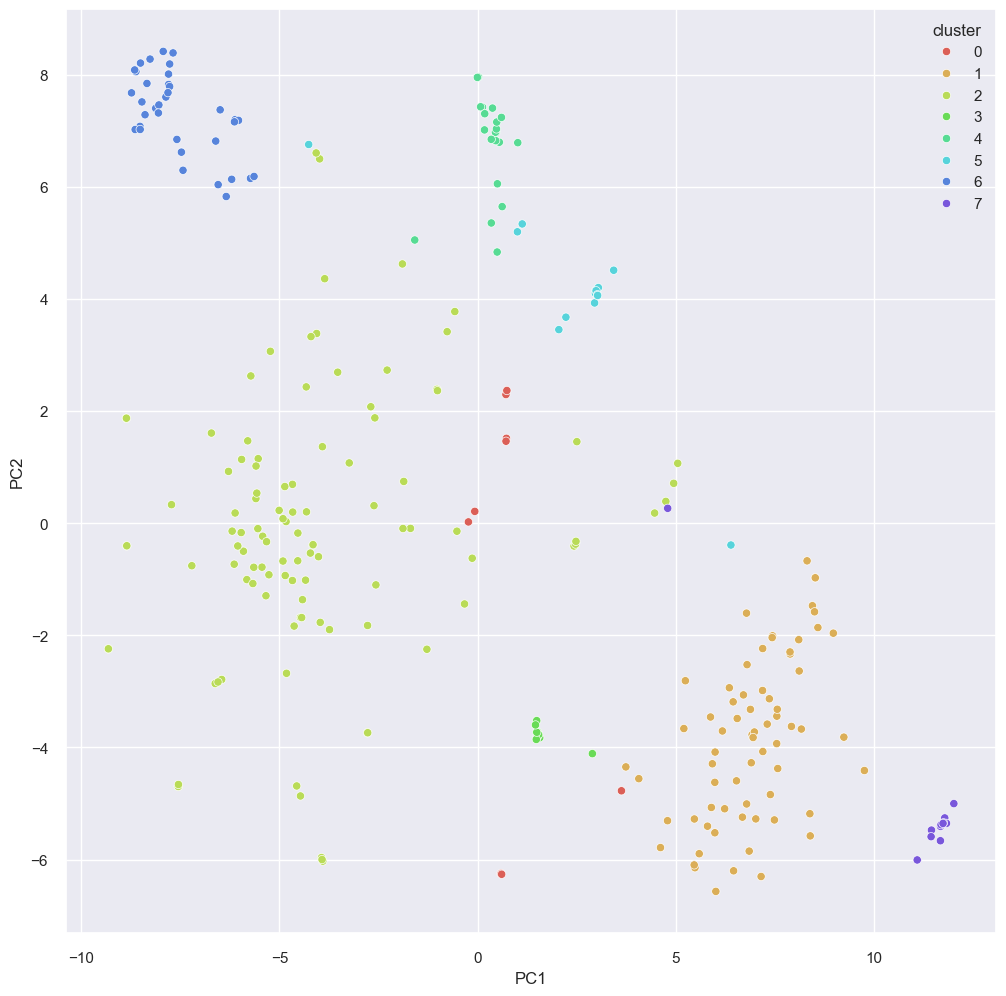

In [77]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(data=tsne_df_es, x='PC1', y='PC2', hue='cluster', palette=sns.color_palette("hls",10), legend="full")

#### Both Embeddings

<Axes: xlabel='PC1', ylabel='PC2'>

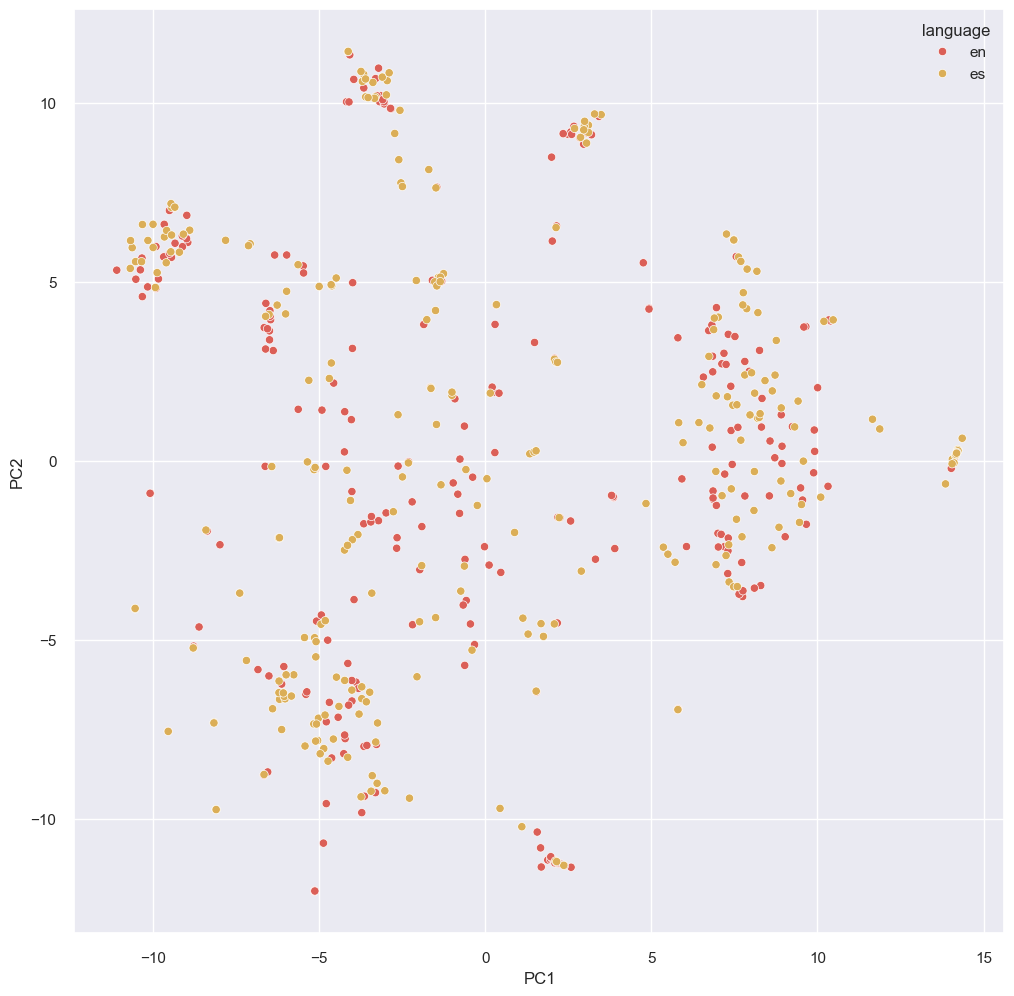

In [124]:
both_embeddings = np.concatenate((en_embeddings, es_embeddings))

pca = PCA(n_components=50)
principalComponents = pca.fit_transform(both_embeddings)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(principalComponents)

tsne_df = pd.concat([en_df_clusters, es_df_clusters])
tsne_df['PC1'] = tsne_pca_results[:,0]
tsne_df['PC2'] = tsne_pca_results[:,1]

tsne_df = tsne_df.reset_index()

for idx, row in tsne_df.iterrows():
    if idx < 280:
        tsne_df.at[idx, 'language'] = 'en'
    else:
        tsne_df.at[idx, 'language'] = 'es'

sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(data=tsne_df, x='PC1', y='PC2', hue='language', palette=sns.color_palette("hls",10), legend="full")

### Interactive Plotly Graphs

In [72]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

#### English

In [219]:
color_map = {i:px.colors.qualitative.Plotly[i] for i in range(10)}
lang = tsne_df_en['cluster'].map(color_map)

fig = go.Figure()

for cluster_value, cluster_color in color_map.items():
    cluster_data = tsne_df_en[tsne_df_en['cluster'] == cluster_value]
    fig.add_trace(go.Scatter(
        x=cluster_data['PC1'],
        y=cluster_data['PC2'],
        mode='markers',
        marker=dict(color=cluster_color, size=10),
        text=cluster_data['text'],
        name=cluster_value,
    ))

fig.update_layout(
    autosize=False,
    width=1500,
    height=1500,
    legend=dict(title='Cluster'),
    xaxis_title='PC1',
    yaxis_title='PC2'
)

fig.show()

#### Spanish

In [224]:
color_map = {i:px.colors.qualitative.Plotly[i] for i in range(10)}
lang = tsne_df_es['cluster'].map(color_map)

fig = go.Figure()

for cluster_value, cluster_color in color_map.items():
    cluster_data = tsne_df_es[tsne_df_es['cluster'] == cluster_value]
    fig.add_trace(go.Scatter(
        x=cluster_data['PC1'],
        y=cluster_data['PC2'],
        mode='markers',
        marker=dict(color=cluster_color, size=10),
        text=cluster_data['translation'],
        name=cluster_value,
    ))

fig.update_layout(
    autosize=False,
    width=1500,
    height=1500,
    legend=dict(title='Cluster'),
    xaxis_title='PC1',
    yaxis_title='PC2'
)

fig.show()

#### Both Embeddings

In [116]:
def set_value(row):
    return 1 if row['language'] == 'en' else 2

def set_translation(row):
    return row['translation'] if pd.notnull(row['translation']) else row['text']


In [123]:
data=tsne_df.copy()
data['language'] = data.apply(set_value, axis=1)
data['text'] = data.apply(set_translation, axis=1)

language
1    280
2    280
Name: count, dtype: int64

In [194]:
import plotly.graph_objects as go

color_map = {'en': 'red', 'es': 'orange'}
lang = data['language'].map(color_map)

fig = go.Figure()

for lang_value, lang_color in color_map.items():
    lang_data = data[data['language'] == lang_value]
    fig.add_trace(go.Scatter(
        x=lang_data['PC1'],
        y=lang_data['PC2'],
        mode='markers',
        marker=dict(color=lang_color, size=10),
        text=lang_data['text'],
        name=lang_value,
    ))

fig.update_layout(
    autosize=False,
    width=1500,
    height=1500,
    legend=dict(title='Language'),
    xaxis_title='PCA1',
    yaxis_title='PCA2'
)

fig.show()
